##Pediction New Death Cases Global Covid-19 Cases

####Load Data and Import Libraries

In [1]:
# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
%tensorflow_version 2.x # make sure that collab use tensorflow 2
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import datetime
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # make sure that collab use tensorflow 2`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !rm '/root/.keras/datasets/global_total.csv'

####Load Data


In [0]:
df_new_cases = pd.read_csv("https://raw.githubusercontent.com/virgiawan/covid-19-prediction/linear-regression/dataset/corona-virus/new_cases.csv")

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


In [0]:
step = 0;
times = []
series = []

for case in df_new_cases['World']:
  times.append(step)
  series.append(case)
  step += 1

Total data 151 series


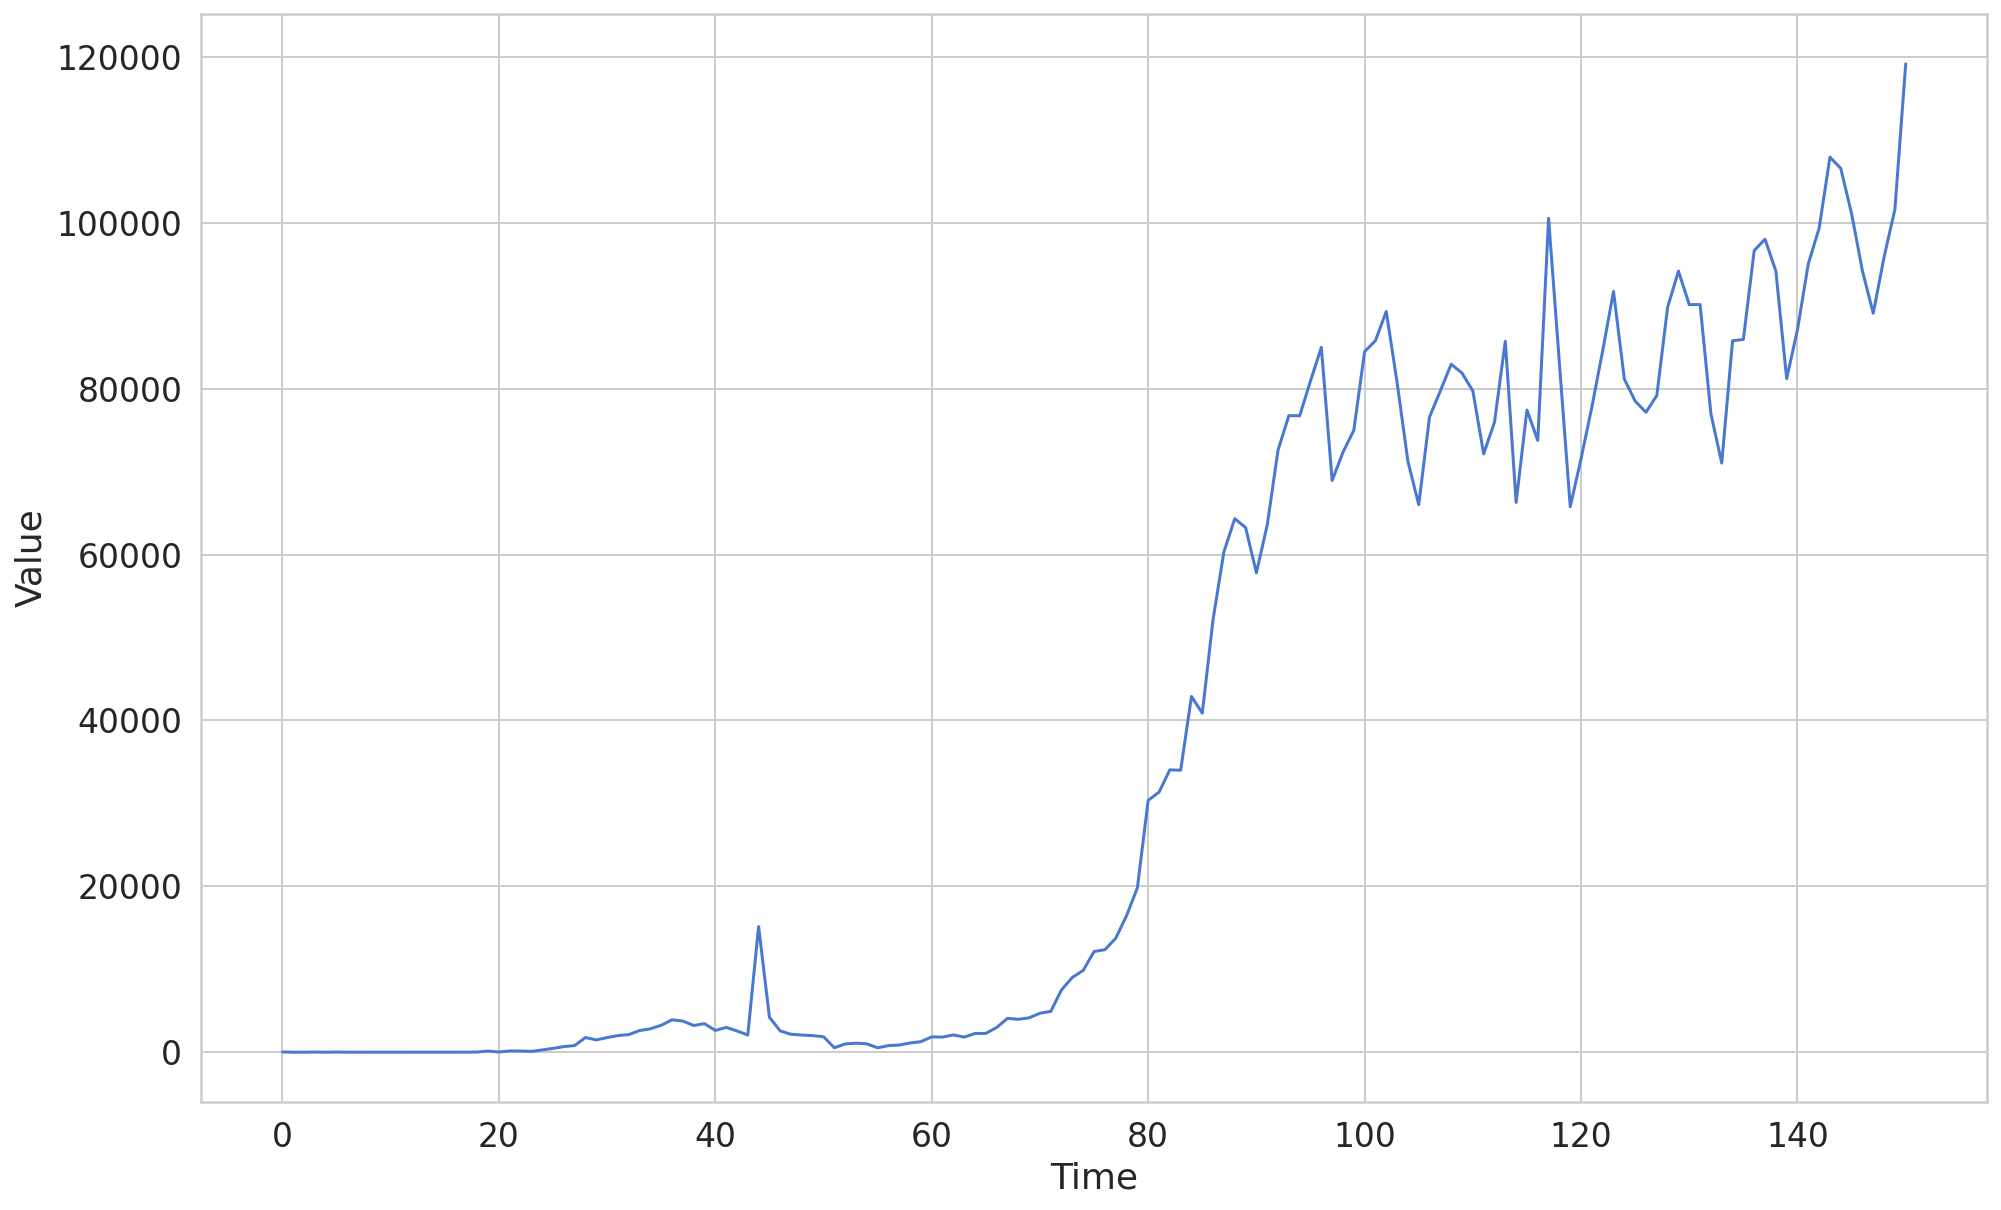

In [6]:
plot_series(times, series)
print('Total data {} series'.format(len(series)))

Total data 88 series


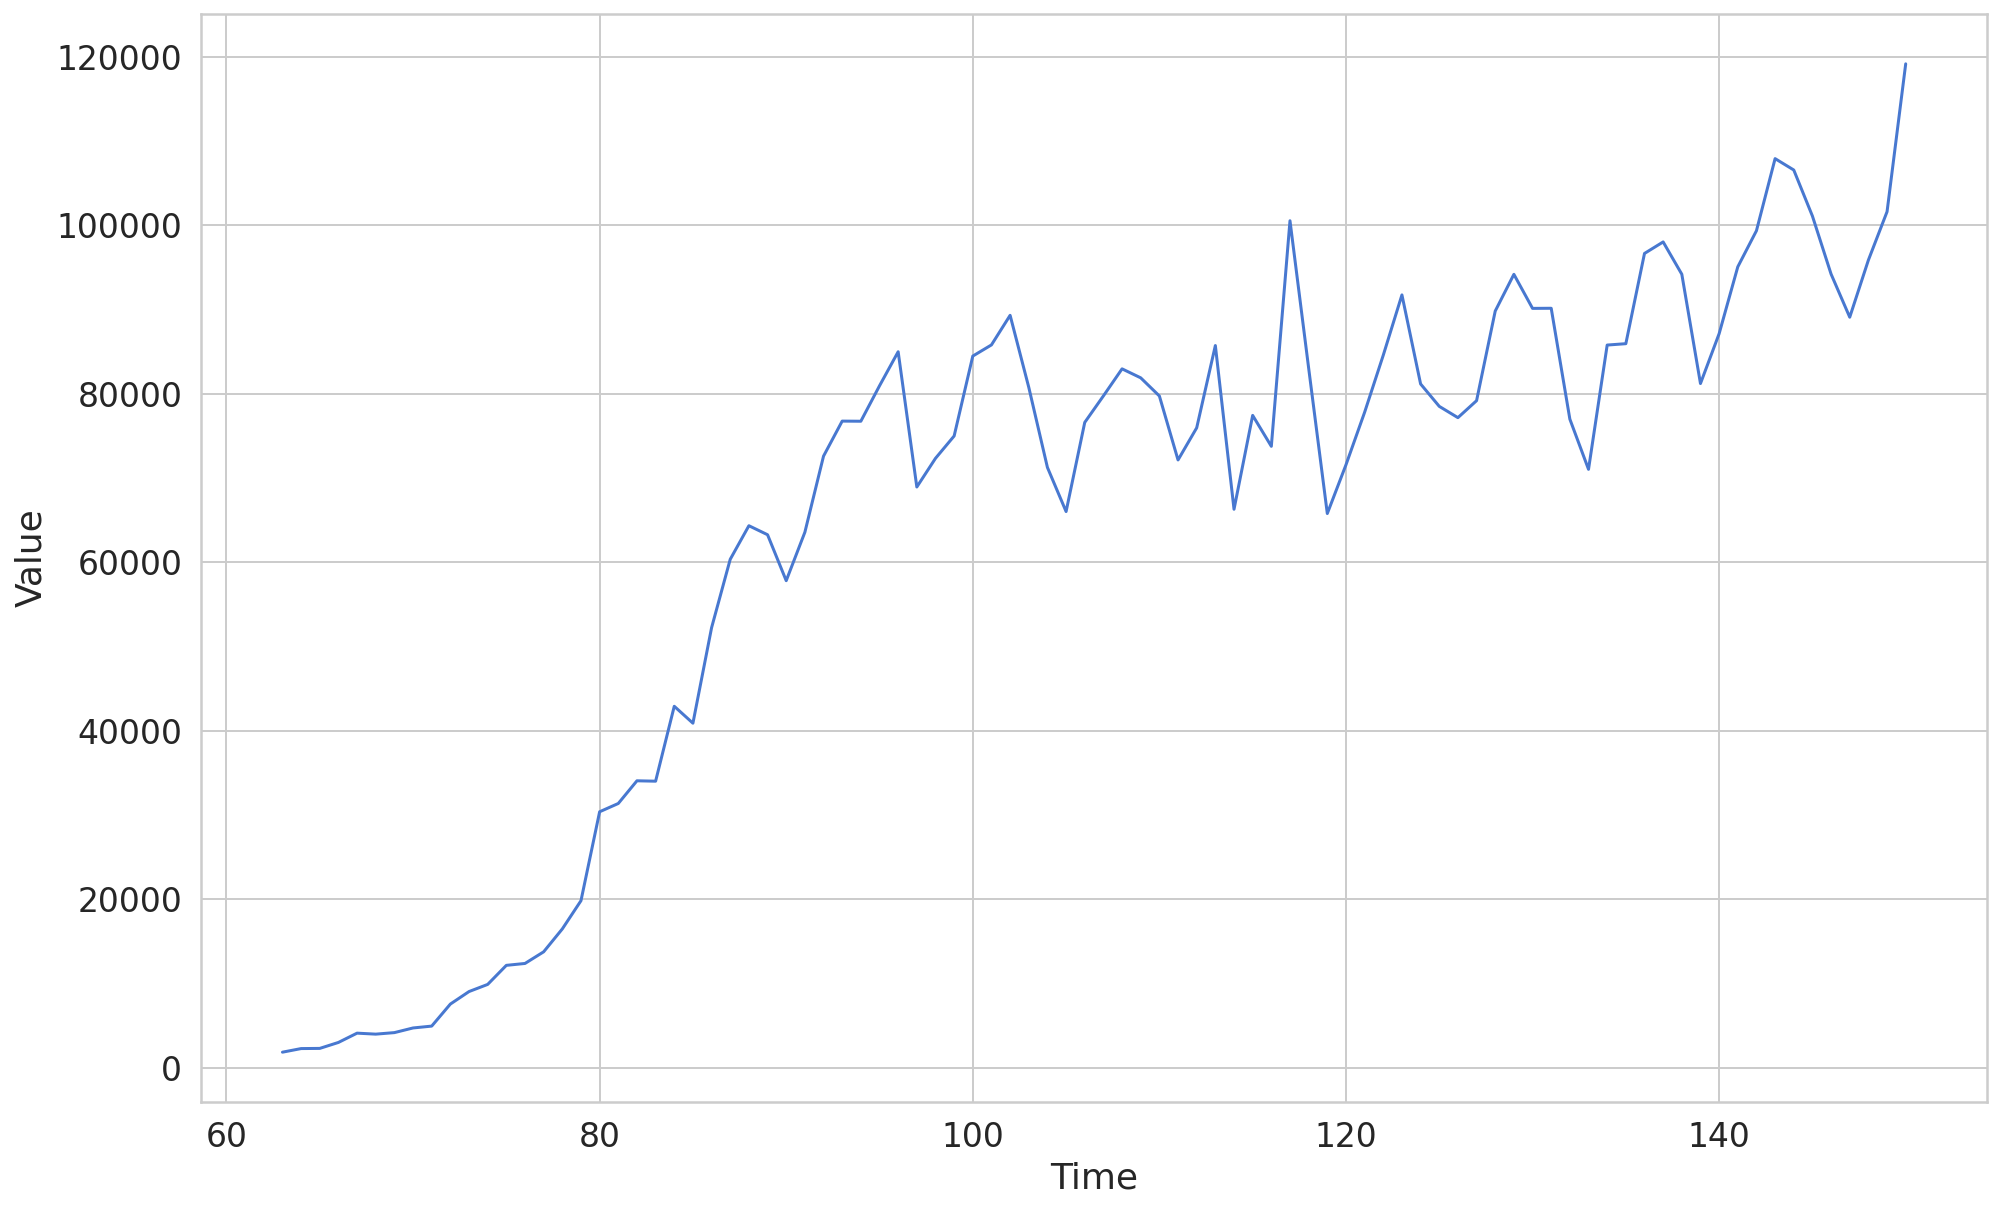

In [7]:
# Series 0 - 63 indicate flat data. Data not increased significantly. 
# Try to ignore it first
skip = 63
used_series = series[skip:]
used_times = times[skip:]

plot_series(used_times, used_series)
print('Total data {} series'.format(len(used_series)))

In [0]:
split_percentage = 0.70
split_time = (int) (len(used_times) * split_percentage)

time_train = used_times[:split_time]
x_train = used_series[:split_time]
time_valid = used_times[split_time:]
x_valid = used_series[split_time:]

In [0]:
# create DNN window
def windowed_dataset_dnn(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


In [0]:
# define hyper parameter
window_size = 20
batch_size = 2
shuffle_buffer_size = 10
epochs = 100

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset_dnn(x_train, window_size, batch_size, shuffle_buffer_size)


l0 = tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1])
l1 = tf.keras.layers.Dense(32, input_shape=[window_size], activation='relu')
l2 = tf.keras.layers.Dense(32, activation='relu')
l3 = tf.keras.layers.Dense(1)
l4 = tf.keras.layers.Lambda(lambda x: x * 10000)

model = tf.keras.models.Sequential([l0, l1, l2, l3, l4])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(dataset, epochs=epochs, callbacks=[lr_schedule], verbose=0)

In [59]:
len_data = 0
for window_dataset in dataset:
  len_data += 1
print('Windows number: {}'.format(len_data))

Windows number: 21


(1e-08, 10.0, 0.0, 100000.0)

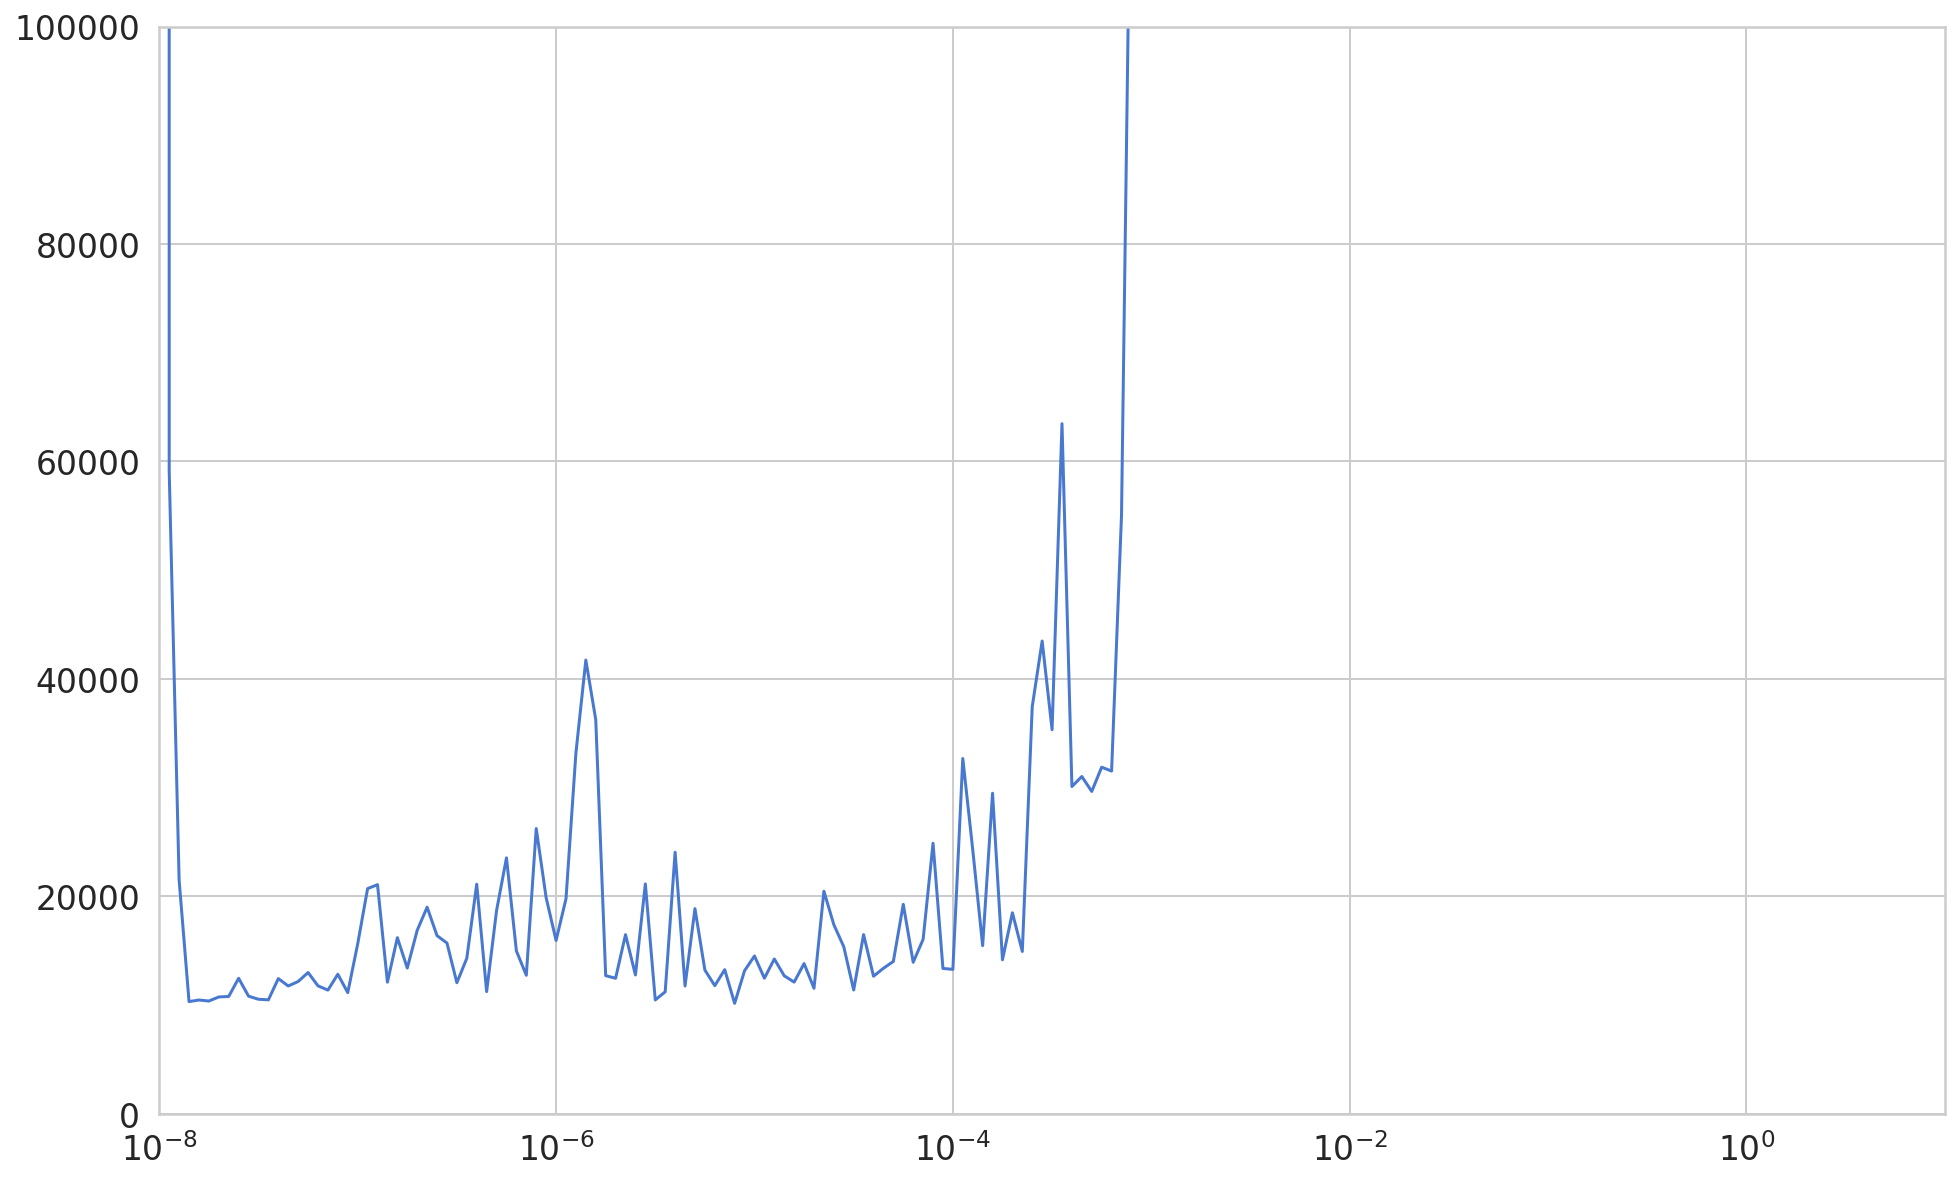

In [60]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 10, 0, 100000])

In [65]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
epochs = 10000

dataset = windowed_dataset_dnn(x_train, window_size, batch_size, shuffle_buffer_size)

l0 = tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1])
l1 = tf.keras.layers.Dense(32, input_shape=[window_size], activation='relu')
l2 = tf.keras.layers.Dense(32, activation='relu')
l3 = tf.keras.layers.Dense(1)
l4 = tf.keras.layers.Lambda(lambda x: x * 10000)

model = tf.keras.models.Sequential([l0, l1, l2, l3, l4])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae', 'acc'])
history = model.fit(dataset, epochs=epochs, verbose=2)

Streaming output truncated to the last 5000 lines.
21/21 - 0s - loss: 12031.5117 - mae: 12032.0117 - acc: 0.0000e+00
Epoch 7502/10000
21/21 - 0s - loss: 14007.5605 - mae: 14008.0605 - acc: 0.0000e+00
Epoch 7503/10000
21/21 - 0s - loss: 13539.8809 - mae: 13540.3809 - acc: 0.0000e+00
Epoch 7504/10000
21/21 - 0s - loss: 14190.0840 - mae: 14190.5840 - acc: 0.0000e+00
Epoch 7505/10000
21/21 - 0s - loss: 11265.3428 - mae: 11265.8428 - acc: 0.0000e+00
Epoch 7506/10000
21/21 - 0s - loss: 14316.3906 - mae: 14316.8906 - acc: 0.0000e+00
Epoch 7507/10000
21/21 - 0s - loss: 12118.9170 - mae: 12119.4170 - acc: 0.0000e+00
Epoch 7508/10000
21/21 - 0s - loss: 11598.4971 - mae: 11598.9971 - acc: 0.0000e+00
Epoch 7509/10000
21/21 - 0s - loss: 12567.6064 - mae: 12568.1064 - acc: 0.0000e+00
Epoch 7510/10000
21/21 - 0s - loss: 12381.3047 - mae: 12381.8047 - acc: 0.0000e+00
Epoch 7511/10000
21/21 - 0s - loss: 11877.7393 - mae: 11878.2393 - acc: 0.0000e+00
Epoch 7512/10000
21/21 - 0s - loss: 13484.3105 - mae:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


(0.6309604994325533, 10000.0, 4000.0, 25000.0)

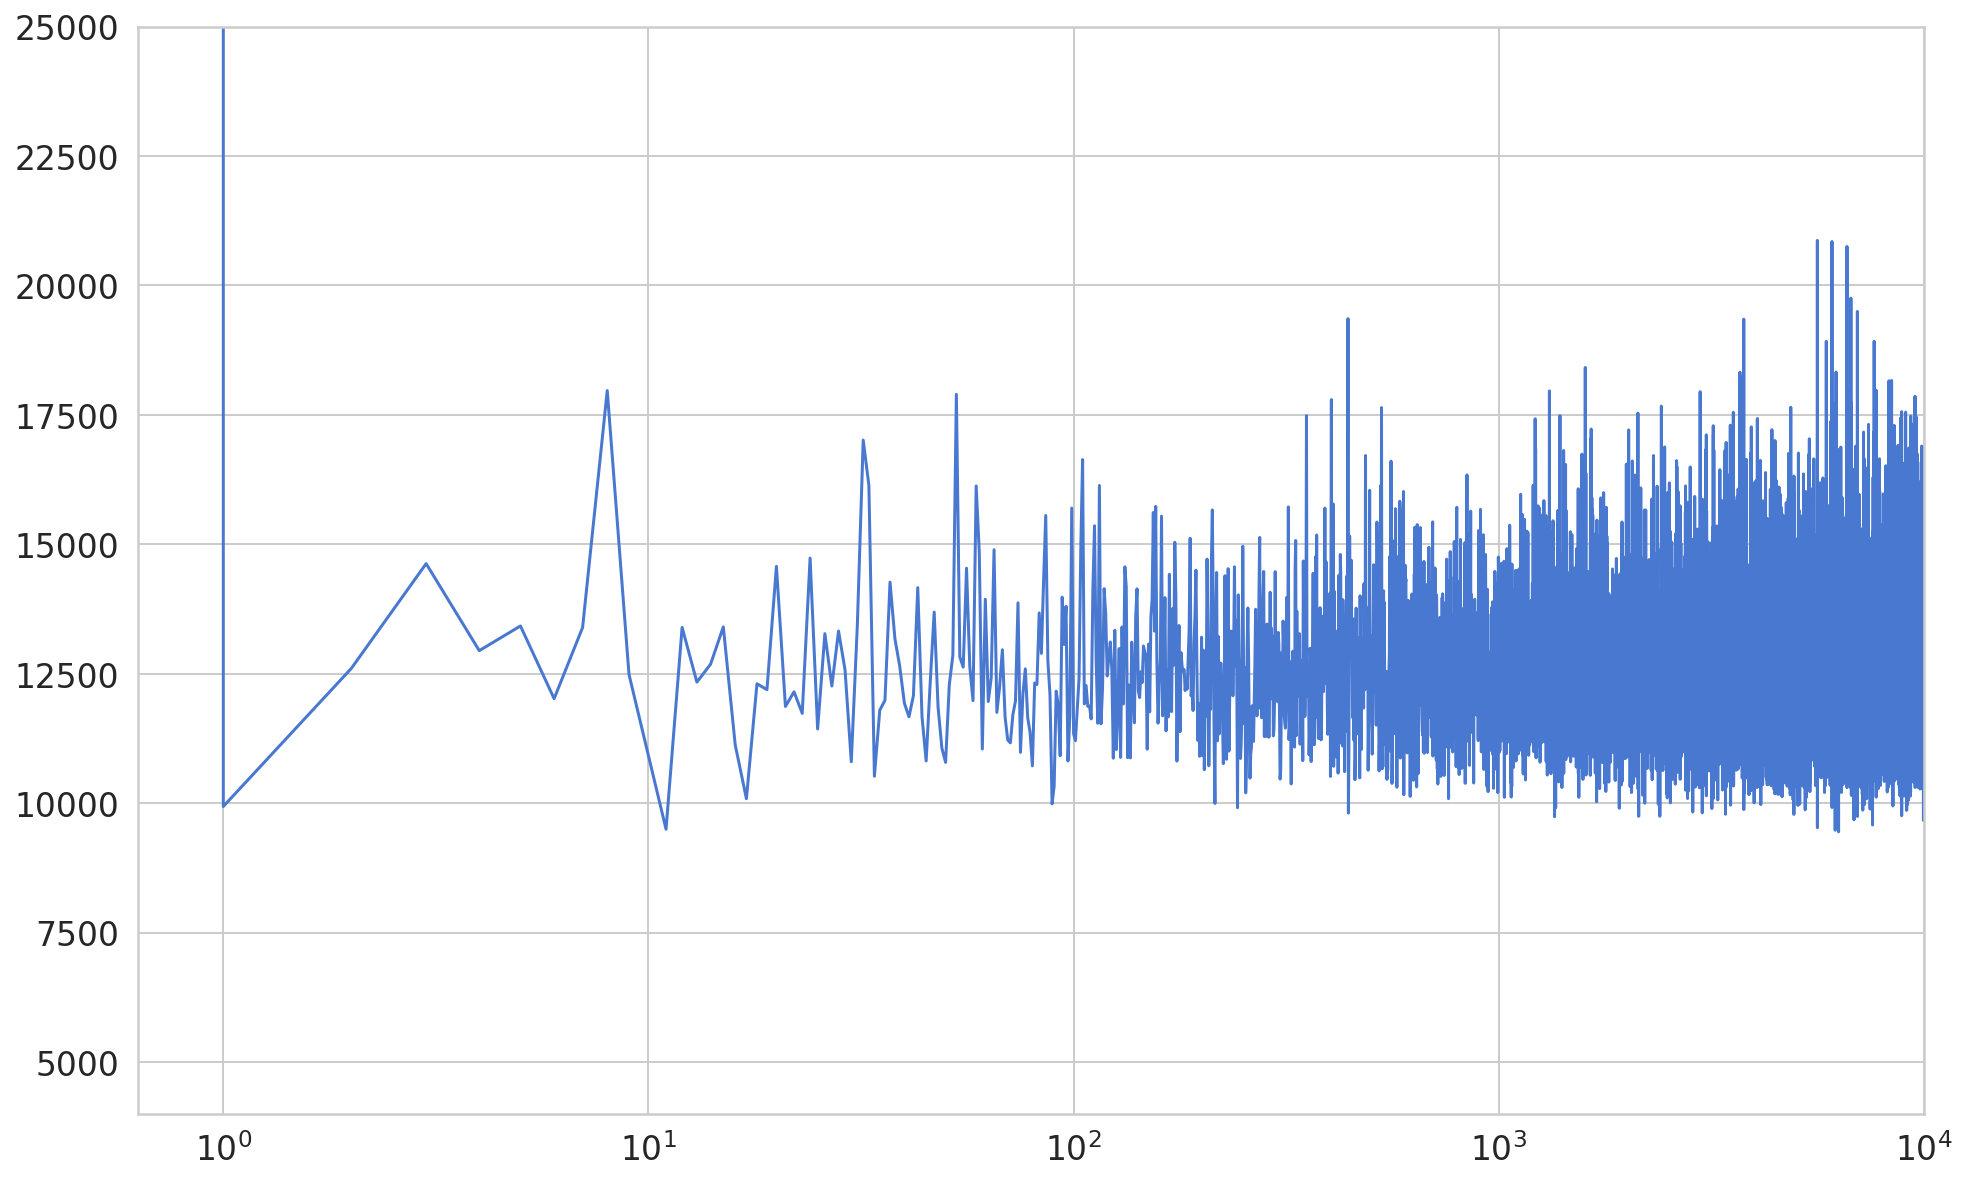

In [70]:
plt.semilogx(range(0, epochs), history.history["loss"])
plt.axis([0, 10000, 4000, 25000])

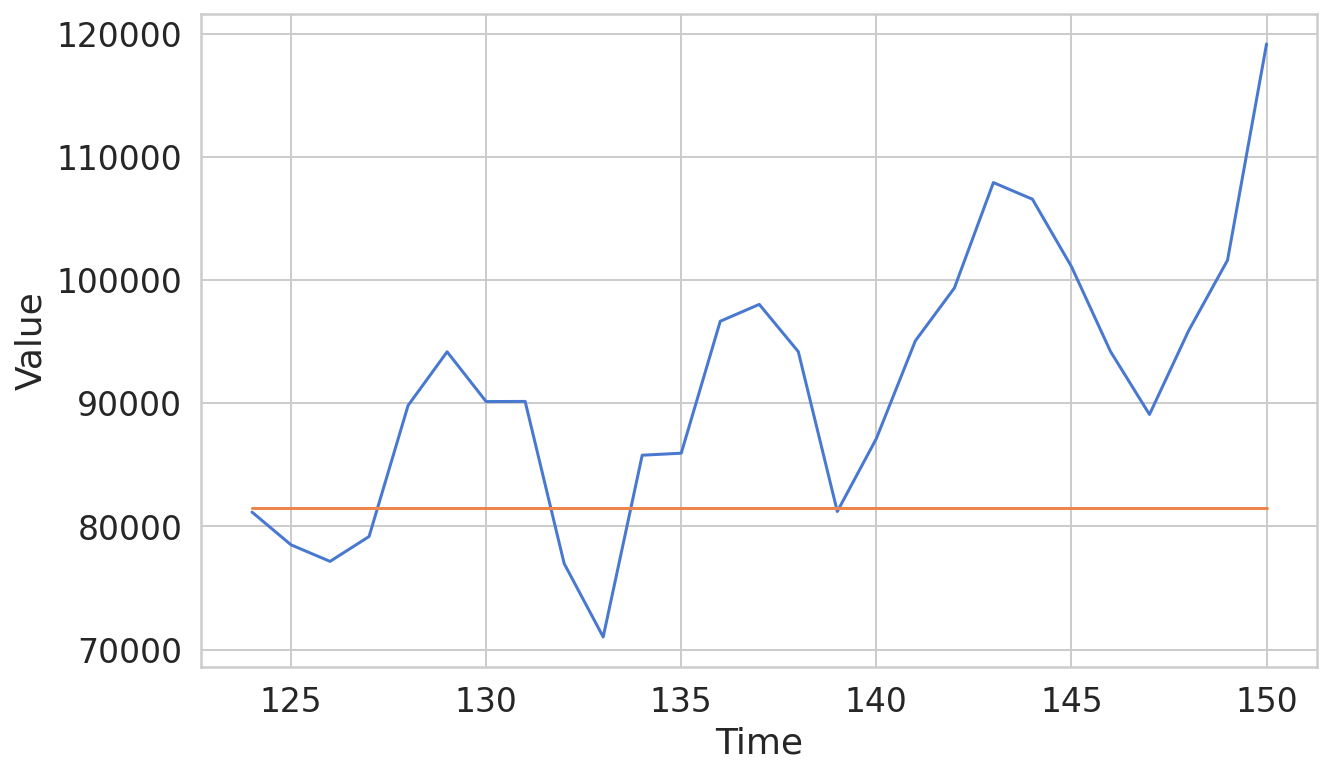

In [72]:
forecast = []
np_used_series = np.array(used_series)
np_used_series = tf.expand_dims(np_used_series, axis=-1)

for time in range(len(np_used_series) - window_size):
  forecast.append(model.predict(np_used_series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

32631.125